# <center>A modified visual system simulation model improves the robustness of white box adversarial attack (VoneNet)</center>
# <center> Team Member: Shilong Wu, Yinglong Li, Jingze Liu, Yuqi Lei</center>

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn
seaborn.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization,ReLU
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from sklearn.metrics import f1_score
import scipy.stats as stats
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# <center>EfficientNet_B0_1024 Model</center>

In [2]:
def EfficientNet_B0_Dense1024(img_size, lr, class_count):  
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x=Dense(1024,activation='relu')(x)
    output=Dense(class_count, activation='sigmoid')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy']) 
    return model

# <center>Basic VoneNet Model</center>

In [3]:
def gabor_kernel(frequency, sigma_x, sigma_y, theta=0, offset=0, ks=61):
    w = ks // 2
    grid_val = tf.range(-w, w+1, dtype=tf.float32)
    x, y = tf.meshgrid(grid_val, grid_val)
    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)
    g = tf.exp(-0.5 * (rotx ** 2 / sigma_x ** 2 + roty ** 2 / sigma_y ** 2))
    g /= 2 * np.pi * sigma_x * sigma_y
    g *= tf.cos(2 * np.pi * frequency * rotx + offset)

    return g


class Identity(layers.Layer):
    def call(self, inputs):
        return inputs


class GFB(layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=4):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

        self.weight = tf.Variable(tf.zeros(
            (kernel_size, kernel_size, in_channels, out_channels)), trainable=False)

    def call(self, inputs):
        return tf.nn.conv2d(inputs, self.weight, strides=[1, self.stride, self.stride, 1], padding='SAME')

    def initialize(self, sf, theta, sigx, sigy, phase):
        random_channel = tf.random.uniform(
            (self.out_channels,), minval=0, maxval=self.in_channels, dtype=tf.int32)
#         for i in range(self.out_channels):
#             self.weight[i, random_channel[i]] = gabor_kernel(frequency=sf[i], sigma_x=sigx[i], sigma_y=sigy[i],
#                                                              theta=theta[i], offset=phase[i], ks=self.kernel_size)
#         self.weight.assign(self.weight)
        for i in range(self.out_channels):
            gabor = gabor_kernel(frequency=sf[i], sigma_x=sigx[i], sigma_y=sigy[i],
                                     theta=theta[i], offset=phase[i], ks=self.kernel_size)

            # 使用scatter_nd_update更新权重
#             tensor_i = tf.constant(i, dtype=tf.int32)  # 将 i 转换为张量
#             indices = tf.constant([[tensor_i, random_channel[i]]], dtype=tf.int32)
# #             indices = tf.constant([[i, random_channel[i]]], dtype=tf.int32)
#             updates = tf.expand_dims(gabor, axis=0)
#             self.weight = tf.tensor_scatter_nd_update(self.weight, indices, updates)
#             tensor_i = tf.constant(i, dtype=tf.int32)  # 将 i 转换为张量
#             tensor_channel = tf.constant(random_channel[i], dtype=tf.int32)  # 将 random_channel[i] 转换为张量
#             indices = tf.expand_dims(tf.stack([tensor_i, tensor_channel]), axis=0)  # 堆叠张量并增加维度
#             updates = tf.expand_dims(gabor, axis=0)
#             self.weight = tf.tensor_scatter_nd_update(self.weight, indices, updates)

            kernel = gabor_kernel(frequency=sf[i], sigma_x=sigx[i], sigma_y=sigy[i],
                                  theta=theta[i], offset=phase[i], ks=self.kernel_size)
            self.weight[:, :, random_channel[i], i].assign(kernel)

class VOneBlock(layers.Layer):
    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):
        super().__init__()

        self.in_channels = 3
        self.simple_channels = simple_channels
        self.complex_channels = complex_channels
        self.out_channels = simple_channels + complex_channels
        self.stride = stride
        self.input_size = input_size

        self.sf = sf
        self.theta = theta
        self.sigx = sigx
        self.sigy = sigy
        self.phase = phase
        self.k_exc = k_exc

        self.set_noise_mode(noise_mode, noise_scale, noise_level)
        self.fixed_noise = None

        self.simple_conv_q0 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q1 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q0.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase)
        self.simple_conv_q1.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 2)

        self.simple = layers.ReLU()
        self.complex = Identity()
        self.gabors = Identity()
        self.noise = layers.ReLU()
        self.output_layer = Identity()

    def call(self, inputs):
        x = self.gabors_f(inputs)
        x = self.noise_f(x)
        x = self.output_layer(x)
        return x

    def gabors_f(self, inputs):
        s_q0 = self.simple_conv_q0(inputs)
        s_q1 = self.simple_conv_q1(inputs)
        c = self.complex(tf.math.sqrt(s_q0[:, :, :, self.simple_channels:] ** 2 +
                                      s_q1[:, :, :, self.simple_channels:] ** 2) / np.sqrt(2))
        s = self.simple(s_q0[:, :, :, :self.simple_channels])

        return self.gabors(self.k_exc * tf.concat((s, c), axis=-1))

    def noise_f(self, inputs):
        x = inputs
        if self.noise_mode == 'neuronal':
            eps = 10e-5
            x *= self.noise_scale
            x += self.noise_level
            if self.fixed_noise is not None:
                x += self.fixed_noise * tf.math.sqrt(tf.nn.relu(x) + eps)
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * \
                    tf.math.sqrt(tf.nn.relu(x) + eps)
            x -= self.noise_level
            x /= self.noise_scale
        if self.noise_mode == 'gaussian':
            if self.fixed_noise is not None:
                x += self.fixed_noise * self.noise_scale
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * self.noise_scale
        return self.noise(x)

    def set_noise_mode(self, noise_mode=None, noise_scale=1, noise_level=1):
        self.noise_mode = noise_mode
        self.noise_scale = noise_scale
        self.noise_level = noise_level

    def fix_noise(self, batch_size=256, seed=None):
        if seed:
            tf.random.set_seed(seed)
        noise_mean = tf.zeros((batch_size, int(
            self.input_size / self.stride), int(self.input_size / self.stride), self.out_channels))
        if self.noise_mode:
            self.fixed_noise = tf.random.normal(noise_mean.shape, stddev=1)

    def unfix_noise(self):
        self.fixed_noise = None


def sample_dist(hist, bins, ns, scale='linear'):
    rand_sample = np.random.rand(ns)
    if scale == 'linear':
        rand_sample = np.interp(
            rand_sample, np.hstack(([0], hist.cumsum())), bins)
    elif scale == 'log2':
        rand_sample = np.interp(rand_sample, np.hstack(
            ([0], hist.cumsum())), np.log2(bins))
        rand_sample = 2**rand_sample
    elif scale == 'log10':
        rand_sample = np.interp(rand_sample, np.hstack(
            ([0], hist.cumsum())), np.log10(bins))
        rand_sample = 10**rand_sample
    return rand_sample


def generate_gabor_param(features, seed=0, rand_flag=False, sf_corr=0, sf_max=9, sf_min=0):
    # Generates random sample
    np.random.seed(seed)

    phase_bins = np.array([0, 360])
    phase_dist = np.array([1])

    if rand_flag:
        print('Uniform gabor parameters')
        ori_bins = np.array([0, 180])
        ori_dist = np.array([1])

        nx_bins = np.array([0.1, 10**0.2])
        nx_dist = np.array([1])

        ny_bins = np.array([0.1, 10**0.2])
        ny_dist = np.array([1])

        # sf_bins = np.array([0.5, 8])
        # sf_dist = np.array([1])

        sf_bins = np.array([0.5, 0.7, 1.0, 1.4, 2.0, 2.8, 4.0, 5.6, 8])
        sf_dist = np.array([1,  1,  1, 1, 1, 1, 1, 1])

        sfmax_ind = np.where(sf_bins < sf_max)[0][-1]
        sfmin_ind = np.where(sf_bins >= sf_min)[0][0]

        sf_bins = sf_bins[sfmin_ind:sfmax_ind+1]
        sf_dist = sf_dist[sfmin_ind:sfmax_ind]

        sf_dist = sf_dist / sf_dist.sum()
    else:
        print('Neuronal distributions gabor parameters')
        # DeValois 1982a
        ori_bins = np.array([-22.5, 22.5, 67.5, 112.5, 157.5])
        ori_dist = np.array([66, 49, 77, 54])
        ori_dist = ori_dist / ori_dist.sum()

        # Schiller 1976
        cov_mat = np.array([[1, sf_corr], [sf_corr, 1]])

        # Ringach 2002b
        nx_bins = np.logspace(-1, 0.2, 6, base=10)
        ny_bins = np.logspace(-1, 0.2, 6, base=10)
        n_joint_dist = np.array([[2.,  0.,  1.,  0.,  0.],
                                 [8.,  9.,  4.,  1.,  0.],
                                 [1.,  2., 19., 17.,  3.],
                                 [0.,  0.,  1.,  7.,  4.],
                                 [0.,  0.,  0.,  0.,  0.]])
        n_joint_dist = n_joint_dist / n_joint_dist.sum()
        nx_dist = n_joint_dist.sum(axis=1)
        nx_dist = nx_dist / nx_dist.sum()
        ny_dist_marg = n_joint_dist / n_joint_dist.sum(axis=1, keepdims=True)

        # DeValois 1982b
        sf_bins = np.array([0.5, 0.7, 1.0, 1.4, 2.0, 2.8, 4.0, 5.6, 8])
        sf_dist = np.array([4,  4,  8, 25, 32, 26, 28, 12])

        sfmax_ind = np.where(sf_bins <= sf_max)[0][-1]
        sfmin_ind = np.where(sf_bins >= sf_min)[0][0]

        sf_bins = sf_bins[sfmin_ind:sfmax_ind+1]
        sf_dist = sf_dist[sfmin_ind:sfmax_ind]

        sf_dist = sf_dist / sf_dist.sum()

    phase = sample_dist(phase_dist, phase_bins, features)
    ori = sample_dist(ori_dist, ori_bins, features)
    ori[ori < 0] = ori[ori < 0] + 180

    if rand_flag:
        sf = sample_dist(sf_dist, sf_bins, features, scale='log2')
        nx = sample_dist(nx_dist, nx_bins, features, scale='log10')
        ny = sample_dist(ny_dist, ny_bins, features, scale='log10')
    else:

        samps = np.random.multivariate_normal([0, 0], cov_mat, features)
        samps_cdf = stats.norm.cdf(samps)

        nx = np.interp(samps_cdf[:, 0], np.hstack(
            ([0], nx_dist.cumsum())), np.log10(nx_bins))
        nx = 10**nx

        ny_samp = np.random.rand(features)
        ny = np.zeros(features)
        for samp_ind, nx_samp in enumerate(nx):
            bin_id = np.argwhere(nx_bins < nx_samp)[-1]
            ny[samp_ind] = np.interp(ny_samp[samp_ind], np.hstack(([0], ny_dist_marg[bin_id, :].cumsum())),
                                     np.log10(ny_bins))
        ny = 10**ny

        sf = np.interp(samps_cdf[:, 1], np.hstack(
            ([0], sf_dist.cumsum())), np.log2(sf_bins))
        sf = 2**sf

    return sf, ori, phase, nx, ny


def VOneNet(sf_corr=0.75, sf_max=9, sf_min=0, rand_param=False, gabor_seed=0,
            simple_channels=256, complex_channels=256,
            noise_mode='neuronal', noise_scale=0.35, noise_level=0.07, k_exc=25,
            model_arch='resnet50', image_size=300, visual_degrees=8, ksize=25, stride=4, class_count=14):

    out_channels = simple_channels + complex_channels

    sf, theta, phase, nx, ny = generate_gabor_param(
        out_channels, gabor_seed, rand_param, sf_corr, sf_max, sf_min)

    gabor_params = {'simple_channels': simple_channels, 'complex_channels': complex_channels, 'rand_param': rand_param,
                    'gabor_seed': gabor_seed, 'sf_max': sf_max, 'sf_corr': sf_corr, 'sf': sf.copy(),
                    'theta': theta.copy(), 'phase': phase.copy(), 'nx': nx.copy(), 'ny': ny.copy()}
    arch_params = {'k_exc': k_exc, 'arch': model_arch,
                   'ksize': ksize, 'stride': stride}

    # Conversions
    ppd = image_size / visual_degrees

    sf = sf / ppd
    sigx = nx / sf
    sigy = ny / sf
    theta = theta/180 * np.pi
    phase = phase / 180 * np.pi

    vone_block = VOneBlock(sf=sf, theta=theta, sigx=sigx, sigy=sigy, phase=phase,
                           k_exc=k_exc, noise_mode=noise_mode, noise_scale=noise_scale, noise_level=noise_level,
                           simple_channels=simple_channels, complex_channels=complex_channels,
                           ksize=ksize, stride=stride, input_size=image_size)
    
    
    
    
    img_shape=(image_size,image_size,3)
#     model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
#     inputs = tf.keras.Input(shape=(image_size, image_size, 3))
#     x = vone_block(inputs)
    
    
#     if model_arch:
    bottleneck = Conv2D(3, kernel_size=1, strides=1, use_bias=False,kernel_initializer=tf.keras.initializers.HeNormal())

#         # if model_arch.lower() == 'resnet50':
#         #     print('Model: ', 'VOneResnet50')
#         #     model_back_end = ResNetBackEnd(
#         #         block=Bottleneck, layers=[3, 4, 6, 3])
#         # elif model_arch.lower() == 'alexnet':
#         #     print('Model: ', 'VOneAlexNet')
#         #     model_back_end = AlexNetBackEnd()
#         # elif model_arch.lower() == 'cornets':
#         #     print('Model: ', 'VOneCORnet-S')
#         #     model_back_end = CORnetSBackEnd()
#         # TODO: change model_back_end to our block

    inputs = tf.keras.Input(shape=(image_size, image_size, 3))
    x = vone_block(inputs)
    x = bottleneck(x)
    
    
    # 获取模型后端的输入张量
#     backend_input = model_back_end.input

#     print(x.shape)
#     assert(False)
    
    
    model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=x.shape[1:], pooling='max')
    
#     print(backend_input.shape)

    
    # 用 bottleneck 的输出替换模型后端的输入张量
    backend_output = model_back_end(x)
    
    
    x=backend_output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x=Dense(1024,activation='relu')(x)
    outputs=Dense(class_count, activation='sigmoid')(x)

    
#     outputs = model_back_end.output
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(Adamax(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy']) 
#     else:
#         print('Model: ', 'VOneNet')
#         model = vone_block

    model.image_size = image_size
    model.visual_degrees = visual_degrees
    model.gabor_parms = gabor_params
    model.arch_params = arch_params

    return model

# <center>VOneNet_with_Only_Simple_GFBs</center>

In [4]:
class VOneBlock_Only_Simple_GFBs(layers.Layer):
    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):
        super().__init__()

        self.in_channels = 3
        self.simple_channels = simple_channels
        self.complex_channels = complex_channels
        self.out_channels = simple_channels + complex_channels
        self.stride = stride
        self.input_size = input_size

        self.sf = sf
        self.theta = theta
        self.sigx = sigx
        self.sigy = sigy
        self.phase = phase
        self.k_exc = k_exc

        self.set_noise_mode(noise_mode, noise_scale, noise_level)
        self.fixed_noise = None

        self.simple_conv_q0 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q1 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        self.simple_conv_q0.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase)
        self.simple_conv_q1.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 2)

        self.simple = layers.ReLU()
        self.complex = Identity()
        self.gabors = Identity()
        self.noise = layers.ReLU()
        self.output_layer = Identity()

    def call(self, inputs):
        x = self.gabors_f(inputs)
        x = self.noise_f(x)
        x = self.output_layer(x)
        return x

    def gabors_f(self, inputs):
        s_q0 = self.simple_conv_q0(inputs)
        s_q1 = self.simple_conv_q1(inputs)
        c = self.complex(tf.math.sqrt(s_q0[:, :, :, self.simple_channels:] ** 2 +
                                      s_q1[:, :, :, self.simple_channels:] ** 2 ) / np.sqrt(2))
        s = self.simple(s_q0[:, :, :, :self.simple_channels])

        return self.gabors(self.k_exc * s)

    def noise_f(self, inputs):
        x = inputs
        if self.noise_mode == 'neuronal':
            eps = 10e-5
            x *= self.noise_scale
            x += self.noise_level
            if self.fixed_noise is not None:
                x += self.fixed_noise * tf.math.sqrt(tf.nn.relu(x) + eps)
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * \
                    tf.math.sqrt(tf.nn.relu(x) + eps)
            x -= self.noise_level
            x /= self.noise_scale
        if self.noise_mode == 'gaussian':
            if self.fixed_noise is not None:
                x += self.fixed_noise * self.noise_scale
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * self.noise_scale
        return self.noise(x)

    def set_noise_mode(self, noise_mode=None, noise_scale=1, noise_level=1):
        self.noise_mode = noise_mode
        self.noise_scale = noise_scale
        self.noise_level = noise_level

    def fix_noise(self, batch_size=256, seed=None):
        if seed:
            tf.random.set_seed(seed)
        noise_mean = tf.zeros((batch_size, int(
            self.input_size / self.stride), int(self.input_size / self.stride), self.out_channels))
        if self.noise_mode:
            self.fixed_noise = tf.random.normal(noise_mean.shape, stddev=1)

    def unfix_noise(self):
        self.fixed_noise = None

        
        
        
        
        
        


def VOneNet_with_Only_Simple_GFBs(sf_corr=0.75, sf_max=9, sf_min=0, rand_param=False, gabor_seed=0,
            simple_channels=256, complex_channels=256,
            noise_mode='neuronal', noise_scale=0.35, noise_level=0.07, k_exc=25,
            model_arch='resnet50', image_size=300, visual_degrees=8, ksize=25, stride=4, class_count=14):

    out_channels = simple_channels + complex_channels

    sf, theta, phase, nx, ny = generate_gabor_param(
        out_channels, gabor_seed, rand_param, sf_corr, sf_max, sf_min)

    gabor_params = {'simple_channels': simple_channels, 'complex_channels': complex_channels, 'rand_param': rand_param,
                    'gabor_seed': gabor_seed, 'sf_max': sf_max, 'sf_corr': sf_corr, 'sf': sf.copy(),
                    'theta': theta.copy(), 'phase': phase.copy(), 'nx': nx.copy(), 'ny': ny.copy()}
    arch_params = {'k_exc': k_exc, 'arch': model_arch,
                   'ksize': ksize, 'stride': stride}

    # Conversions
    ppd = image_size / visual_degrees

    sf = sf / ppd
    sigx = nx / sf
    sigy = ny / sf
    theta = theta/180 * np.pi
    phase = phase / 180 * np.pi

    vone_block = VOneBlock_Only_Simple_GFBs(sf=sf, theta=theta, sigx=sigx, sigy=sigy, phase=phase,
                           k_exc=k_exc, noise_mode=noise_mode, noise_scale=noise_scale, noise_level=noise_level,
                           simple_channels=simple_channels, complex_channels=complex_channels,
                           ksize=ksize, stride=stride, input_size=image_size)
    
    
    
    
    img_shape=(image_size,image_size,3)
#     model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
#     inputs = tf.keras.Input(shape=(image_size, image_size, 3))
#     x = vone_block(inputs)
    
    
#     if model_arch:
    bottleneck = Conv2D(3, kernel_size=1, strides=1, use_bias=False,kernel_initializer=tf.keras.initializers.HeNormal())

#         # if model_arch.lower() == 'resnet50':
#         #     print('Model: ', 'VOneResnet50')
#         #     model_back_end = ResNetBackEnd(
#         #         block=Bottleneck, layers=[3, 4, 6, 3])
#         # elif model_arch.lower() == 'alexnet':
#         #     print('Model: ', 'VOneAlexNet')
#         #     model_back_end = AlexNetBackEnd()
#         # elif model_arch.lower() == 'cornets':
#         #     print('Model: ', 'VOneCORnet-S')
#         #     model_back_end = CORnetSBackEnd()
#         # TODO: change model_back_end to our block

    inputs = tf.keras.Input(shape=(image_size, image_size, 3))
    x = vone_block(inputs)
    x = bottleneck(x)
    
    
    # 获取模型后端的输入张量
#     backend_input = model_back_end.input

#     print(x.shape)
#     assert(False)
    
    
    model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=x.shape[1:], pooling='max')
#     model_back_end.trainable = True
#     print(backend_input.shape)

    
    # 用 bottleneck 的输出替换模型后端的输入张量
    backend_output = model_back_end(x)
    
    
    x=backend_output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x=Dense(1024,activation='relu')(x)
    outputs=Dense(class_count, activation='sigmoid')(x)

    
#     outputs = model_back_end.output
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(Adamax(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy']) 
#     else:
#         print('Model: ', 'VOneNet')
#         model = vone_block

    model.image_size = image_size
    model.visual_degrees = visual_degrees
    model.gabor_parms = gabor_params
    model.arch_params = arch_params

    return model


# <center>VOneNet_with_4_GFBs</center>

In [5]:
class VOneBlock_Four_GFBs(layers.Layer):
    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):
        super().__init__()

        self.in_channels = 3
        self.simple_channels = simple_channels
        self.complex_channels = complex_channels
        self.out_channels = simple_channels + complex_channels
        self.stride = stride
        self.input_size = input_size

        self.sf = sf
        self.theta = theta
        self.sigx = sigx
        self.sigy = sigy
        self.phase = phase
        self.k_exc = k_exc

        self.set_noise_mode(noise_mode, noise_scale, noise_level)
        self.fixed_noise = None

        self.simple_conv_q0 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q1 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q2 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q3 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        self.simple_conv_q0.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase)
        self.simple_conv_q1.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 4)
        self.simple_conv_q2.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 2)
        self.simple_conv_q3.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 3 / 4)

        self.simple = layers.ReLU()
        self.complex = Identity()
        self.gabors = Identity()
        self.noise = layers.ReLU()
        self.output_layer = Identity()

    def call(self, inputs):
        x = self.gabors_f(inputs)
        x = self.noise_f(x)
        x = self.output_layer(x)
        return x

    def gabors_f(self, inputs):
        s_q0 = self.simple_conv_q0(inputs)
        s_q1 = self.simple_conv_q1(inputs)
        s_q2 = self.simple_conv_q2(inputs)
        s_q3 = self.simple_conv_q3(inputs)
        c = self.complex(tf.math.sqrt(s_q0[:, :, :, self.simple_channels:] ** 2 +
                                      s_q1[:, :, :, self.simple_channels:] ** 2 +
                                      s_q2[:, :, :, self.simple_channels:] ** 2 +
                                      s_q3[:, :, :, self.simple_channels:] ** 2) / np.sqrt(4))
        s = self.simple(s_q0[:, :, :, :self.simple_channels])

        return self.gabors(self.k_exc * tf.concat((s, c), axis=-1))

    def noise_f(self, inputs):
        x = inputs
        if self.noise_mode == 'neuronal':
            eps = 10e-5
            x *= self.noise_scale
            x += self.noise_level
            if self.fixed_noise is not None:
                x += self.fixed_noise * tf.math.sqrt(tf.nn.relu(x) + eps)
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * \
                    tf.math.sqrt(tf.nn.relu(x) + eps)
            x -= self.noise_level
            x /= self.noise_scale
        if self.noise_mode == 'gaussian':
            if self.fixed_noise is not None:
                x += self.fixed_noise * self.noise_scale
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * self.noise_scale
        return self.noise(x)

    def set_noise_mode(self, noise_mode=None, noise_scale=1, noise_level=1):
        self.noise_mode = noise_mode
        self.noise_scale = noise_scale
        self.noise_level = noise_level

    def fix_noise(self, batch_size=256, seed=None):
        if seed:
            tf.random.set_seed(seed)
        noise_mean = tf.zeros((batch_size, int(
            self.input_size / self.stride), int(self.input_size / self.stride), self.out_channels))
        if self.noise_mode:
            self.fixed_noise = tf.random.normal(noise_mean.shape, stddev=1)

    def unfix_noise(self):
        self.fixed_noise = None

        
        
        
        
        
        


def VOneNet_with_four_GFBs(sf_corr=0.75, sf_max=9, sf_min=0, rand_param=False, gabor_seed=0,
            simple_channels=256, complex_channels=256,
            noise_mode='neuronal', noise_scale=0.35, noise_level=0.07, k_exc=25,
            model_arch='resnet50', image_size=300, visual_degrees=8, ksize=25, stride=4, class_count=14):

    out_channels = simple_channels + complex_channels

    sf, theta, phase, nx, ny = generate_gabor_param(
        out_channels, gabor_seed, rand_param, sf_corr, sf_max, sf_min)

    gabor_params = {'simple_channels': simple_channels, 'complex_channels': complex_channels, 'rand_param': rand_param,
                    'gabor_seed': gabor_seed, 'sf_max': sf_max, 'sf_corr': sf_corr, 'sf': sf.copy(),
                    'theta': theta.copy(), 'phase': phase.copy(), 'nx': nx.copy(), 'ny': ny.copy()}
    arch_params = {'k_exc': k_exc, 'arch': model_arch,
                   'ksize': ksize, 'stride': stride}

    # Conversions
    ppd = image_size / visual_degrees

    sf = sf / ppd
    sigx = nx / sf
    sigy = ny / sf
    theta = theta/180 * np.pi
    phase = phase / 180 * np.pi

    vone_block = VOneBlock_Four_GFBs(sf=sf, theta=theta, sigx=sigx, sigy=sigy, phase=phase,
                           k_exc=k_exc, noise_mode=noise_mode, noise_scale=noise_scale, noise_level=noise_level,
                           simple_channels=simple_channels, complex_channels=complex_channels,
                           ksize=ksize, stride=stride, input_size=image_size)
    
    
    
    
    img_shape=(image_size,image_size,3)
#     model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
#     inputs = tf.keras.Input(shape=(image_size, image_size, 3))
#     x = vone_block(inputs)
    
    
#     if model_arch:
    bottleneck = Conv2D(3, kernel_size=1, strides=1, use_bias=False,kernel_initializer=tf.keras.initializers.HeNormal())

#         # if model_arch.lower() == 'resnet50':
#         #     print('Model: ', 'VOneResnet50')
#         #     model_back_end = ResNetBackEnd(
#         #         block=Bottleneck, layers=[3, 4, 6, 3])
#         # elif model_arch.lower() == 'alexnet':
#         #     print('Model: ', 'VOneAlexNet')
#         #     model_back_end = AlexNetBackEnd()
#         # elif model_arch.lower() == 'cornets':
#         #     print('Model: ', 'VOneCORnet-S')
#         #     model_back_end = CORnetSBackEnd()
#         # TODO: change model_back_end to our block

    inputs = tf.keras.Input(shape=(image_size, image_size, 3))
    x = vone_block(inputs)
    x = bottleneck(x)
    
    
    # 获取模型后端的输入张量
#     backend_input = model_back_end.input

#     print(x.shape)
#     assert(False)
    
    
    model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=x.shape[1:], pooling='max')
    model_back_end.trainable = True
#     print(backend_input.shape)

    
    # 用 bottleneck 的输出替换模型后端的输入张量
    backend_output = model_back_end(x)
    
    
    x=backend_output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x=Dense(1024,activation='relu')(x)
    outputs=Dense(class_count, activation='sigmoid')(x)

    
#     outputs = model_back_end.output
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(Adamax(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy']) 
#     else:
#         print('Model: ', 'VOneNet')
#         model = vone_block

    model.image_size = image_size
    model.visual_degrees = visual_degrees
    model.gabor_parms = gabor_params
    model.arch_params = arch_params

    return model


# <center>VOneNet_with_8_GFBs</center>

In [6]:
class VOneBlock_Eight_GFBs(layers.Layer):
    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):
        super().__init__()

        self.in_channels = 3
        self.simple_channels = simple_channels
        self.complex_channels = complex_channels
        self.out_channels = simple_channels + complex_channels
        self.stride = stride
        self.input_size = input_size

        self.sf = sf
        self.theta = theta
        self.sigx = sigx
        self.sigy = sigy
        self.phase = phase
        self.k_exc = k_exc

        self.set_noise_mode(noise_mode, noise_scale, noise_level)
        self.fixed_noise = None

        self.simple_conv_q0 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q1 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q2 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q3 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        self.simple_conv_q4 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q5 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q6 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q7 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        self.simple_conv_q0.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase)
        self.simple_conv_q1.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 8)
        self.simple_conv_q2.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 2 / 8)
        self.simple_conv_q3.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 3 / 8)
        self.simple_conv_q4.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 4 / 8)
        self.simple_conv_q5.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 5 / 8)
        self.simple_conv_q6.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 6 / 8)
        self.simple_conv_q7.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 7 / 8)

        self.simple = layers.ReLU()
        self.complex = Identity()
        self.gabors = Identity()
        self.noise = layers.ReLU()
        self.output_layer = Identity()

    def call(self, inputs):
        x = self.gabors_f(inputs)
        x = self.noise_f(x)
        x = self.output_layer(x)
        return x

    def gabors_f(self, inputs):
        s_q0 = self.simple_conv_q0(inputs)
        s_q1 = self.simple_conv_q1(inputs)
        s_q2 = self.simple_conv_q2(inputs)
        s_q3 = self.simple_conv_q3(inputs)
        s_q4 = self.simple_conv_q4(inputs)
        s_q5 = self.simple_conv_q5(inputs)
        s_q6 = self.simple_conv_q6(inputs)
        s_q7 = self.simple_conv_q7(inputs)
        c = self.complex(tf.math.sqrt(s_q0[:, :, :, self.simple_channels:] ** 2 +
                                      s_q1[:, :, :, self.simple_channels:] ** 2 +
                                      s_q2[:, :, :, self.simple_channels:] ** 2 +
                                      s_q3[:, :, :, self.simple_channels:] ** 2 +
                                      s_q4[:, :, :, self.simple_channels:] ** 2 +
                                      s_q5[:, :, :, self.simple_channels:] ** 2 +
                                      s_q6[:, :, :, self.simple_channels:] ** 2 +
                                      s_q7[:, :, :, self.simple_channels:] ** 2 ) / np.sqrt(8))
        s = self.simple(s_q0[:, :, :, :self.simple_channels])

        return self.gabors(self.k_exc * tf.concat((s, c), axis=-1))

    def noise_f(self, inputs):
        x = inputs
        if self.noise_mode == 'neuronal':
            eps = 10e-5
            x *= self.noise_scale
            x += self.noise_level
            if self.fixed_noise is not None:
                x += self.fixed_noise * tf.math.sqrt(tf.nn.relu(x) + eps)
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * \
                    tf.math.sqrt(tf.nn.relu(x) + eps)
            x -= self.noise_level
            x /= self.noise_scale
        if self.noise_mode == 'gaussian':
            if self.fixed_noise is not None:
                x += self.fixed_noise * self.noise_scale
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * self.noise_scale
        return self.noise(x)

    def set_noise_mode(self, noise_mode=None, noise_scale=1, noise_level=1):
        self.noise_mode = noise_mode
        self.noise_scale = noise_scale
        self.noise_level = noise_level

    def fix_noise(self, batch_size=256, seed=None):
        if seed:
            tf.random.set_seed(seed)
        noise_mean = tf.zeros((batch_size, int(
            self.input_size / self.stride), int(self.input_size / self.stride), self.out_channels))
        if self.noise_mode:
            self.fixed_noise = tf.random.normal(noise_mean.shape, stddev=1)

    def unfix_noise(self):
        self.fixed_noise = None

        
        
        
        
        
        


def VOneNet_with_eight_GFBs(sf_corr=0.75, sf_max=9, sf_min=0, rand_param=False, gabor_seed=0,
            simple_channels=256, complex_channels=256,
            noise_mode='neuronal', noise_scale=0.35, noise_level=0.07, k_exc=25,
            model_arch='resnet50', image_size=300, visual_degrees=8, ksize=25, stride=4, class_count=14):

    out_channels = simple_channels + complex_channels

    sf, theta, phase, nx, ny = generate_gabor_param(
        out_channels, gabor_seed, rand_param, sf_corr, sf_max, sf_min)

    gabor_params = {'simple_channels': simple_channels, 'complex_channels': complex_channels, 'rand_param': rand_param,
                    'gabor_seed': gabor_seed, 'sf_max': sf_max, 'sf_corr': sf_corr, 'sf': sf.copy(),
                    'theta': theta.copy(), 'phase': phase.copy(), 'nx': nx.copy(), 'ny': ny.copy()}
    arch_params = {'k_exc': k_exc, 'arch': model_arch,
                   'ksize': ksize, 'stride': stride}

    # Conversions
    ppd = image_size / visual_degrees

    sf = sf / ppd
    sigx = nx / sf
    sigy = ny / sf
    theta = theta/180 * np.pi
    phase = phase / 180 * np.pi

    vone_block = VOneBlock_Eight_GFBs(sf=sf, theta=theta, sigx=sigx, sigy=sigy, phase=phase,
                           k_exc=k_exc, noise_mode=noise_mode, noise_scale=noise_scale, noise_level=noise_level,
                           simple_channels=simple_channels, complex_channels=complex_channels,
                           ksize=ksize, stride=stride, input_size=image_size)
    
    
    
    
    img_shape=(image_size,image_size,3)
#     model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
#     inputs = tf.keras.Input(shape=(image_size, image_size, 3))
#     x = vone_block(inputs)
    
    
#     if model_arch:
    bottleneck = Conv2D(3, kernel_size=1, strides=1, use_bias=False,kernel_initializer=tf.keras.initializers.HeNormal())

#         # if model_arch.lower() == 'resnet50':
#         #     print('Model: ', 'VOneResnet50')
#         #     model_back_end = ResNetBackEnd(
#         #         block=Bottleneck, layers=[3, 4, 6, 3])
#         # elif model_arch.lower() == 'alexnet':
#         #     print('Model: ', 'VOneAlexNet')
#         #     model_back_end = AlexNetBackEnd()
#         # elif model_arch.lower() == 'cornets':
#         #     print('Model: ', 'VOneCORnet-S')
#         #     model_back_end = CORnetSBackEnd()
#         # TODO: change model_back_end to our block

    inputs = tf.keras.Input(shape=(image_size, image_size, 3))
    x = vone_block(inputs)
    x = bottleneck(x)
    
    
    # 获取模型后端的输入张量
#     backend_input = model_back_end.input

#     print(x.shape)
#     assert(False)
    
    
    model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=x.shape[1:], pooling='max')
    model_back_end.trainable = True
#     print(backend_input.shape)

    
    # 用 bottleneck 的输出替换模型后端的输入张量
    backend_output = model_back_end(x)
    
    
    x=backend_output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x=Dense(1024,activation='relu')(x)
    outputs=Dense(class_count, activation='sigmoid')(x)

    
#     outputs = model_back_end.output
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(Adamax(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy']) 
#     else:
#         print('Model: ', 'VOneNet')
#         model = vone_block

    model.image_size = image_size
    model.visual_degrees = visual_degrees
    model.gabor_parms = gabor_params
    model.arch_params = arch_params

    return model


# <center>VOneNet_with_16_GFBs</center>

In [7]:

class VOneBlock_16_GFBs(layers.Layer):
    def __init__(self, sf, theta, sigx, sigy, phase,
                 k_exc=25, noise_mode=None, noise_scale=1, noise_level=1,
                 simple_channels=128, complex_channels=128, ksize=25, stride=4, input_size=224):
        super().__init__()

        self.in_channels = 3
        self.simple_channels = simple_channels
        self.complex_channels = complex_channels
        self.out_channels = simple_channels + complex_channels
        self.stride = stride
        self.input_size = input_size

        self.sf = sf
        self.theta = theta
        self.sigx = sigx
        self.sigy = sigy
        self.phase = phase
        self.k_exc = k_exc

        self.set_noise_mode(noise_mode, noise_scale, noise_level)
        self.fixed_noise = None

        self.simple_conv_q0 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q1 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q2 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q3 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        self.simple_conv_q4 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q5 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q6 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q7 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        
        self.simple_conv_q8 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q9 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q10 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q11 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        self.simple_conv_q12 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q13 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q14 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        self.simple_conv_q15 = GFB(
            self.in_channels, self.out_channels, ksize, stride)
        
        self.simple_conv_q0.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase)
        self.simple_conv_q1.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi / 16)
        self.simple_conv_q2.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 2 / 16)
        self.simple_conv_q3.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 3 / 16)
        self.simple_conv_q4.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 4 / 16)
        self.simple_conv_q5.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 5 / 16)
        self.simple_conv_q6.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 6 / 16)
        self.simple_conv_q7.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 7 / 16)
        
        
        
        self.simple_conv_q8.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 8 / 16)
        self.simple_conv_q9.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 9 / 16)
        self.simple_conv_q10.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 10 / 16)
        self.simple_conv_q11.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 11 / 16)
        self.simple_conv_q12.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 12 / 16)
        self.simple_conv_q13.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 13 / 16)
        self.simple_conv_q14.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 14 / 16)
        self.simple_conv_q15.initialize(sf=self.sf, theta=self.theta, sigx=self.sigx, sigy=self.sigy,
                                       phase=self.phase + np.pi * 15 / 16)

        self.simple = layers.ReLU()
        self.complex = Identity()
        self.gabors = Identity()
        self.noise = layers.ReLU()
        self.output_layer = Identity()

    def call(self, inputs):
        x = self.gabors_f(inputs)
        x = self.noise_f(x)
        x = self.output_layer(x)
        return x

    def gabors_f(self, inputs):
        s_q0 = self.simple_conv_q0(inputs)
        s_q1 = self.simple_conv_q1(inputs)
        s_q2 = self.simple_conv_q2(inputs)
        s_q3 = self.simple_conv_q3(inputs)
        s_q4 = self.simple_conv_q4(inputs)
        s_q5 = self.simple_conv_q5(inputs)
        s_q6 = self.simple_conv_q6(inputs)
        s_q7 = self.simple_conv_q7(inputs)
        
        
        s_q8 = self.simple_conv_q8(inputs)
        s_q9 = self.simple_conv_q9(inputs)
        s_q10 = self.simple_conv_q10(inputs)
        s_q11 = self.simple_conv_q11(inputs)
        s_q12 = self.simple_conv_q12(inputs)
        s_q13 = self.simple_conv_q13(inputs)
        s_q14 = self.simple_conv_q14(inputs)
        s_q15 = self.simple_conv_q15(inputs)
        
        c = self.complex(tf.math.sqrt(s_q0[:, :, :, self.simple_channels:] ** 2 +
                                      s_q1[:, :, :, self.simple_channels:] ** 2 +
                                      s_q2[:, :, :, self.simple_channels:] ** 2 +
                                      s_q3[:, :, :, self.simple_channels:] ** 2 +
                                      s_q4[:, :, :, self.simple_channels:] ** 2 +
                                      s_q5[:, :, :, self.simple_channels:] ** 2 +
                                      s_q6[:, :, :, self.simple_channels:] ** 2 +
                                      s_q7[:, :, :, self.simple_channels:] ** 2 +
                                      s_q8[:, :, :, self.simple_channels:] ** 2 +
                                      s_q9[:, :, :, self.simple_channels:] ** 2 +
                                      s_q10[:, :, :, self.simple_channels:] ** 2 +
                                      s_q11[:, :, :, self.simple_channels:] ** 2 +
                                      s_q12[:, :, :, self.simple_channels:] ** 2 +
                                      s_q13[:, :, :, self.simple_channels:] ** 2 +
                                      s_q14[:, :, :, self.simple_channels:] ** 2 +
                                      s_q15[:, :, :, self.simple_channels:] ** 2
                                     
                                     
                                     ) / np.sqrt(16))
        s = self.simple(s_q0[:, :, :, :self.simple_channels])

        return self.gabors(self.k_exc * tf.concat((s, c), axis=-1))

    def noise_f(self, inputs):
        x = inputs
        if self.noise_mode == 'neuronal':
            eps = 10e-5
            x *= self.noise_scale
            x += self.noise_level
            if self.fixed_noise is not None:
                x += self.fixed_noise * tf.math.sqrt(tf.nn.relu(x) + eps)
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * \
                    tf.math.sqrt(tf.nn.relu(x) + eps)
            x -= self.noise_level
            x /= self.noise_scale
        if self.noise_mode == 'gaussian':
            if self.fixed_noise is not None:
                x += self.fixed_noise * self.noise_scale
            else:
                x += tf.random.normal(tf.shape(x), stddev=1) * self.noise_scale
        return self.noise(x)

    def set_noise_mode(self, noise_mode=None, noise_scale=1, noise_level=1):
        self.noise_mode = noise_mode
        self.noise_scale = noise_scale
        self.noise_level = noise_level

    def fix_noise(self, batch_size=256, seed=None):
        if seed:
            tf.random.set_seed(seed)
        noise_mean = tf.zeros((batch_size, int(
            self.input_size / self.stride), int(self.input_size / self.stride), self.out_channels))
        if self.noise_mode:
            self.fixed_noise = tf.random.normal(noise_mean.shape, stddev=1)

    def unfix_noise(self):
        self.fixed_noise = None

        
        
        
        
        
        


def VOneNet_with_16_GFBs(sf_corr=0.75, sf_max=9, sf_min=0, rand_param=False, gabor_seed=0,
            simple_channels=256, complex_channels=256,
            noise_mode='neuronal', noise_scale=0.35, noise_level=0.07, k_exc=25,
            model_arch='resnet50', image_size=300, visual_degrees=8, ksize=25, stride=4, class_count=14):

    out_channels = simple_channels + complex_channels

    sf, theta, phase, nx, ny = generate_gabor_param(
        out_channels, gabor_seed, rand_param, sf_corr, sf_max, sf_min)

    gabor_params = {'simple_channels': simple_channels, 'complex_channels': complex_channels, 'rand_param': rand_param,
                    'gabor_seed': gabor_seed, 'sf_max': sf_max, 'sf_corr': sf_corr, 'sf': sf.copy(),
                    'theta': theta.copy(), 'phase': phase.copy(), 'nx': nx.copy(), 'ny': ny.copy()}
    arch_params = {'k_exc': k_exc, 'arch': model_arch,
                   'ksize': ksize, 'stride': stride}

    # Conversions
    ppd = image_size / visual_degrees

    sf = sf / ppd
    sigx = nx / sf
    sigy = ny / sf
    theta = theta/180 * np.pi
    phase = phase / 180 * np.pi

    vone_block = VOneBlock_16_GFBs(sf=sf, theta=theta, sigx=sigx, sigy=sigy, phase=phase,
                           k_exc=k_exc, noise_mode=noise_mode, noise_scale=noise_scale, noise_level=noise_level,
                           simple_channels=simple_channels, complex_channels=complex_channels,
                           ksize=ksize, stride=stride, input_size=image_size)
    
    
    
    
    img_shape=(image_size,image_size,3)
#     model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    
#     inputs = tf.keras.Input(shape=(image_size, image_size, 3))
#     x = vone_block(inputs)
    
    
#     if model_arch:
    bottleneck = Conv2D(3, kernel_size=1, strides=1, use_bias=False,kernel_initializer=tf.keras.initializers.HeNormal())

#         # if model_arch.lower() == 'resnet50':
#         #     print('Model: ', 'VOneResnet50')
#         #     model_back_end = ResNetBackEnd(
#         #         block=Bottleneck, layers=[3, 4, 6, 3])
#         # elif model_arch.lower() == 'alexnet':
#         #     print('Model: ', 'VOneAlexNet')
#         #     model_back_end = AlexNetBackEnd()
#         # elif model_arch.lower() == 'cornets':
#         #     print('Model: ', 'VOneCORnet-S')
#         #     model_back_end = CORnetSBackEnd()
#         # TODO: change model_back_end to our block

    inputs = tf.keras.Input(shape=(image_size, image_size, 3))
    x = vone_block(inputs)
    x = bottleneck(x)
    
    
    # 获取模型后端的输入张量
#     backend_input = model_back_end.input

#     print(x.shape)
#     assert(False)
    
    
    model_back_end=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=x.shape[1:], pooling='max')
    model_back_end.trainable = True
#     print(backend_input.shape)

    
    # 用 bottleneck 的输出替换模型后端的输入张量
    backend_output = model_back_end(x)
    
    
    x=backend_output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x=Dense(1024,activation='relu')(x)
    outputs=Dense(class_count, activation='sigmoid')(x)

    
#     outputs = model_back_end.output
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(Adamax(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy']) 
#     else:
#         print('Model: ', 'VOneNet')
#         model = vone_block

    model.image_size = image_size
    model.visual_degrees = visual_degrees
    model.gabor_parms = gabor_params
    model.arch_params = arch_params

    return model

<a id="pc"></a>

# <center>Generating filtered CSV file</center>

In [8]:
import os
import glob

datapath=r'../input/pizza-images-with-topping-labels/pizza_data/labels.csv'
df=pd.read_csv(datapath)

dir_path = '/kaggle/input/vonenet-adv/kaggle/working/output'
files = glob.glob(os.path.join(dir_path, '*'))
file_names = set([os.path.basename(file) for file in files])

# print(file_names)

mask = df['image_name'].isin(file_names)
new_df = df[mask]

new_df.to_csv('filtered.csv', index=False)

# <center>Generating DataFlow for Original images</center>

In [9]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/original/kaggle/working/output'

df=pd.read_csv(datapath)
df['plain']=0
columns=df.columns

df['image_name']=df['image_name'].apply(lambda x: os.path.join(imgpath,x))
df = df.rename(columns={'image_name': 'filepaths'})

for i in range (len(df)):
    label_list=[]
    for j in range (1,len(df.columns)-1):
        column=df.columns[j]        
        label=df.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df['plain'].iloc[i]=1
print('df length: ', len(df)) 

df length:  497


In [10]:
img_size=(300,300)
columns=df.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_original=generator.flow_from_dataframe(df, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 497 validated image filenames.


# <center>Generating DataFlow for Attacked images for EfficientNet_B0_1024</center>

In [11]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/efficient-adv/kaggle/working/output'

df2=pd.read_csv(datapath)
df2['plain']=0
columns=df2.columns

df2['image_name']=df2['image_name'].apply(lambda x: os.path.join(imgpath,x))
df2 = df2.rename(columns={'image_name': 'filepaths'})

for i in range (len(df2)):
    label_list=[]
    for j in range (1,len(df2.columns)-1):
        column=df2.columns[j]        
        label=df2.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df2['plain'].iloc[i]=1
print('df length: ', len(df2)) 

df length:  497


In [12]:
img_size=(300,300)
columns=df2.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_efficientnet=generator.flow_from_dataframe(df2, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 497 validated image filenames.


# <center>Generating DataFlow for Attacked images for Basic VoneNet eps=0.1</center>

In [13]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/vonenet-adv/kaggle/working/output'

df5=pd.read_csv(datapath)
df5['plain']=0
columns=df5.columns

df5['image_name']=df5['image_name'].apply(lambda x: os.path.join(imgpath,x))
df5 = df5.rename(columns={'image_name': 'filepaths'})

for i in range (len(df5)):
    label_list=[]
    for j in range (1,len(df5.columns)-1):
        column=df5.columns[j]        
        label=df5.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df5['plain'].iloc[i]=1
print('df length: ', len(df5)) 

df length:  497


In [14]:
img_size=(300,300)
columns=df5.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_eps_0=generator.flow_from_dataframe(df5, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 497 validated image filenames.


# <center>Generating DataFlow for Attacked images for Basic VoneNet eps=1</center>

In [15]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/vonenet-adv-eps1/kaggle/working/output'

df3=pd.read_csv(datapath)
df3['plain']=0
columns=df3.columns

df3['image_name']=df3['image_name'].apply(lambda x: os.path.join(imgpath,x))
df3 = df3.rename(columns={'image_name': 'filepaths'})

for i in range (len(df3)):
    label_list=[]
    for j in range (1,len(df3.columns)-1):
        column=df3.columns[j]        
        label=df3.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df3['plain'].iloc[i]=1
print('df length: ', len(df3)) 

df length:  497


In [16]:
img_size=(300,300)
columns=df3.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_eps_1=generator.flow_from_dataframe(df3, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 497 validated image filenames.


# <center>Generating DataFlow for Attacked images for Basic VoneNet eps=5</center>

In [17]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/vonenet-adv-eps5/kaggle/working/output'

df4=pd.read_csv(datapath)
df4['plain']=0
columns=df4.columns

df4['image_name']=df4['image_name'].apply(lambda x: os.path.join(imgpath,x))
df4 = df4.rename(columns={'image_name': 'filepaths'})

for i in range (len(df4)):
    label_list=[]
    for j in range (1,len(df4.columns)-1):
        column=df4.columns[j]        
        label=df4.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df4['plain'].iloc[i]=1
print('df length: ', len(df4)) 

df length:  497


In [18]:
img_size=(300,300)
columns=df4.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_eps_5=generator.flow_from_dataframe(df4, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 497 validated image filenames.


# <center>Generating DataFlow for Attacked images for VOneNet_with_only_simple_GFBs eps=5</center>

In [19]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/vone-simple-adv-eps5/kaggle/working/output'

df6=pd.read_csv(datapath)
df6['plain']=0
columns=df6.columns

df6['image_name']=df6['image_name'].apply(lambda x: os.path.join(imgpath,x))
df6 = df6.rename(columns={'image_name': 'filepaths'})

for i in range (len(df6)):
    label_list=[]
    for j in range (1,len(df6.columns)-1):
        column=df6.columns[j]        
        label=df6.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df6['plain'].iloc[i]=1
print('df length: ', len(df6)) 

df length:  497


In [20]:
img_size=(300,300)
columns=df6.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_only_simple_GFBs_eps_5=generator.flow_from_dataframe(df6, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 489 validated image filenames.


# <center>Generating DataFlow for Attacked images for VOneNet_with_4_GFBs eps=5</center>

In [21]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/vone-4gfbs-adv-eps5/kaggle/working/output'

df7=pd.read_csv(datapath)
df7['plain']=0
columns=df7.columns

df7['image_name']=df7['image_name'].apply(lambda x: os.path.join(imgpath,x))
df7 = df7.rename(columns={'image_name': 'filepaths'})

for i in range (len(df7)):
    label_list=[]
    for j in range (1,len(df7.columns)-1):
        column=df7.columns[j]        
        label=df7.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df7['plain'].iloc[i]=1
print('df length: ', len(df7)) 

df length:  497


In [22]:
img_size=(300,300)
columns=df7.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_4_GFBs_eps_5=generator.flow_from_dataframe(df7, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 489 validated image filenames.


# <center>Generating DataFlow for Attacked images for VOneNet_with_8_GFBs eps=5</center>

In [23]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/vone-8gfbs-adv-eps5/kaggle/working/output'

df8=pd.read_csv(datapath)
df8['plain']=0
columns=df8.columns

df8['image_name']=df8['image_name'].apply(lambda x: os.path.join(imgpath,x))
df8 = df8.rename(columns={'image_name': 'filepaths'})

for i in range (len(df8)):
    label_list=[]
    for j in range (1,len(df8.columns)-1):
        column=df8.columns[j]        
        label=df8.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df8['plain'].iloc[i]=1
print('df length: ', len(df8)) 

df length:  497


In [24]:
img_size=(300,300)
columns=df8.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_8_GFBs_eps_5=generator.flow_from_dataframe(df8, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 489 validated image filenames.


# <center>Generating DataFlow for Attacked images for VOneNet_with_16_GFBs eps=5</center>

In [25]:
datapath=r'../input/filtered1/filtered.csv'
imgpath=r'../input/vone-16gfbs-adv-eps5/kaggle/working/output'

df9=pd.read_csv(datapath)
df9['plain']=0
columns=df9.columns

df9['image_name']=df9['image_name'].apply(lambda x: os.path.join(imgpath,x))
df9 = df9.rename(columns={'image_name': 'filepaths'})

for i in range (len(df9)):
    label_list=[]
    for j in range (1,len(df9.columns)-1):
        column=df9.columns[j]        
        label=df9.iloc[i][column]
        label_list.append(label)
    max=np.max(label_list)        
    if max == 0:         
        df9['plain'].iloc[i]=1
print('df length: ', len(df9)) 

df length:  497


In [26]:
img_size=(300,300)
columns=df9.columns[1:]
class_count=len(columns)
generator=ImageDataGenerator()
test_attacked_16_GFBs_eps_5=generator.flow_from_dataframe(df9, x_col='filepaths', y_col=columns, target_size=img_size, batch_size=30,shuffle=False,class_mode='raw')

Found 489 validated image filenames.


# <center>Test & Compare Results</center>

In [27]:
lr=.001
model_efficientnet=EfficientNet_B0_Dense1024(img_size, lr, class_count)
model_Vonenet=VOneNet()
model_VOneNet_with_only_simple_GFBs=VOneNet_with_Only_Simple_GFBs()
model_VOneNet_with_4_GFBs=VOneNet_with_four_GFBs()
model_VOneNet_with_8_GFBs=VOneNet_with_eight_GFBs()
model_VOneNet_with_16_GFBs=VOneNet_with_16_GFBs()

16719872/16705208 [==============================] - 2s 0us/step
Neuronal distributions gabor parameters
Neuronal distributions gabor parameters
Neuronal distributions gabor parameters
Neuronal distributions gabor parameters
Neuronal distributions gabor parameters


In [28]:
model_efficientnet.load_weights('/kaggle/input/efficientnet/ModelOutput')
model_Vonenet.load_weights('/kaggle/input/voneefficient/ModelOutput')
model_VOneNet_with_only_simple_GFBs.load_weights('/kaggle/input/models/Vonesimple/ModelOutput')
model_VOneNet_with_4_GFBs.load_weights('/kaggle/input/models/Vone4/ModelOutput')
model_VOneNet_with_8_GFBs.load_weights('/kaggle/input/models/Vone8/ModelOutput')
model_VOneNet_with_16_GFBs.load_weights('/kaggle/input/models/Vone16/ModelOutput')

In [29]:
loss, accuracy=model_efficientnet.evaluate(test_original)
print ('test_original_efficientnet', accuracy)

17/17 [==============================] - 13s 299ms/step - loss: 0.2306 - accuracy: 0.6419
test_original_efficientnet 0.6418511271476746


In [30]:
loss, accuracy=model_efficientnet.evaluate(test_attacked_efficientnet)
print ('test_attacked_efficientnet', accuracy)

17/17 [==============================] - 5s 311ms/step - loss: 0.6192 - accuracy: 0.3984
test_attacked_efficientnet 0.39839035272598267


In [31]:
loss, accuracy=model_Vonenet.evaluate(test_original)
print ('test_original_vonenet', accuracy)

17/17 [==============================] - 5s 160ms/step - loss: 0.1075 - accuracy: 0.7364
test_original_vonenet 0.7364184856414795


In [32]:
loss, accuracy=model_Vonenet.evaluate(test_attacked_eps_0)
print ('test_attacked_eps_0.1_vonenet_basic', accuracy)

17/17 [==============================] - 5s 300ms/step - loss: 0.1076 - accuracy: 0.7404
test_attacked_eps_0.1_vonenet_basic 0.7404426336288452


In [33]:
loss, accuracy=model_Vonenet.evaluate(test_attacked_eps_1)
print ('test_attacked_eps_1_vonenet_basic', accuracy)

17/17 [==============================] - 6s 342ms/step - loss: 0.1085 - accuracy: 0.7203
test_attacked_eps_1_vonenet_basic 0.7203219532966614


In [34]:
loss, accuracy=model_Vonenet.evaluate(test_attacked_eps_5)
print ('test_attacked_eps_5_vonenet_basic', accuracy)

17/17 [==============================] - 5s 307ms/step - loss: 0.1072 - accuracy: 0.7364
test_attacked_eps_5_vonenet_basic 0.7364184856414795


In [35]:
loss, accuracy=model_Vonenet.evaluate(test_attacked_only_simple_GFBs_eps_5)
print ('test_attacked_eps_0.5_vonenet_only_simple_GFBs', accuracy)

17/17 [==============================] - 5s 304ms/step - loss: 0.1083 - accuracy: 0.7362
test_attacked_eps_0.5_vonenet_only_simple_GFBs 0.7361963391304016


In [36]:
loss, accuracy=model_Vonenet.evaluate(test_attacked_4_GFBs_eps_5)
print ('test_attacked_eps_0.5_vonenet_4_GFBs', accuracy)

17/17 [==============================] - 5s 306ms/step - loss: 0.1149 - accuracy: 0.7260
test_attacked_eps_0.5_vonenet_4_GFBs 0.7259713411331177


In [37]:
loss, accuracy=model_Vonenet.evaluate(test_attacked_8_GFBs_eps_5)
print ('test_attacked_eps_0.5_vonenet_8_GFBs', accuracy)

17/17 [==============================] - 5s 309ms/step - loss: 0.1059 - accuracy: 0.7505
test_attacked_eps_0.5_vonenet_8_GFBs 0.7505112290382385


In [38]:
loss, accuracy=model_Vonenet.evaluate(test_attacked_16_GFBs_eps_5)
print ('test_attacked_eps_0.5_vonenet_16_GFBs', accuracy)

17/17 [==============================] - 5s 303ms/step - loss: 0.1246 - accuracy: 0.7362
test_attacked_eps_0.5_vonenet_16_GFBs 0.7361963391304016


# <center>Display some samples</center>

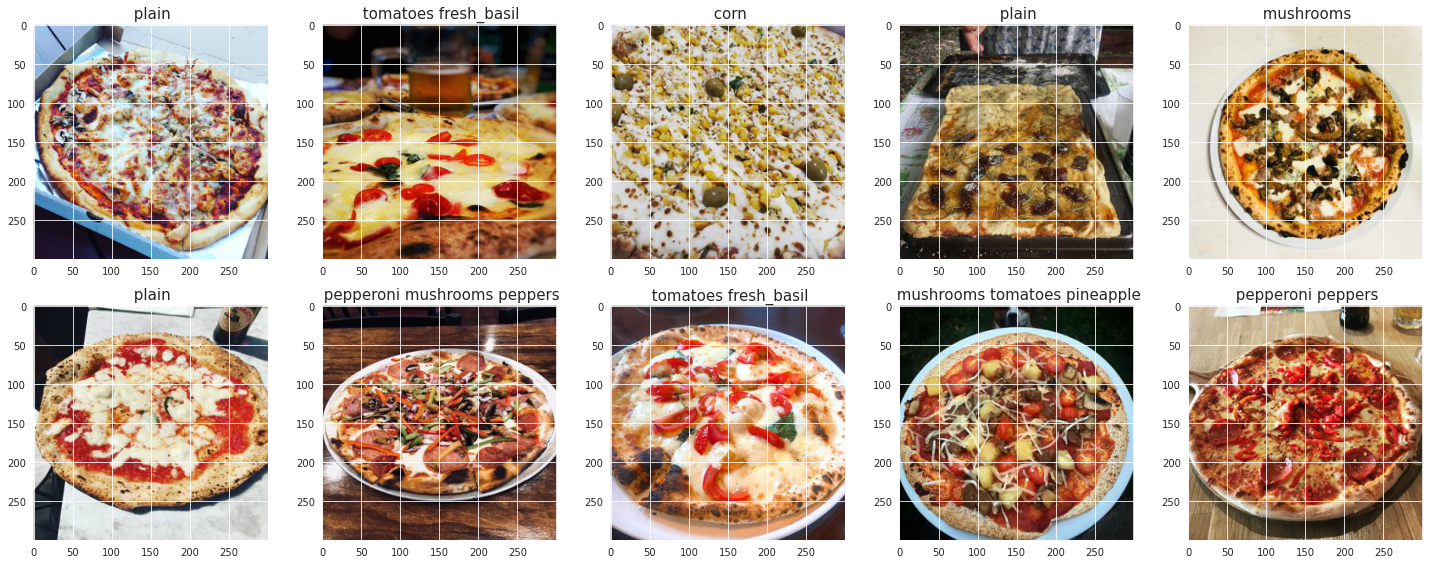

In [39]:
def display_samples(img, classes): 
    images,labels=next(img)
    plt.figure(figsize=(25, 25))
    num_of_images=10
    for i in range(num_of_images):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255 
        label=labels[i]
        title=''
        for j in range(len(label)):
            value=label[j]
            if value == 1:
                title=title + ' '+ classes[j]
        plt.imshow(image)
        fname=os.path.basename(img.filenames[i])        
        plt.title(title, fontsize=15)
    plt.show()
    
display_samples(test_attacked_eps_0, columns)